### Add Tokenized Text and Embeddings to CSVS
Run all of the following cells, in order

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import ast
from gensim.models import KeyedVectors
import nltk
import torch
from ast import literal_eval

Load Dataset

In [2]:
def load_datasets():
    """
    Load training and dev sets
    """

    train = pd.read_csv("./new_dataset/train_preprocessed.csv")
    dev = pd.read_csv("./new_dataset/val_preprocessed.csv")
    
    return train, dev

Tokenizing Input Text and Adding to Train and Dev Dataframes

In [3]:
def tokenizer(text: str):
    '''
    NLTK Tweet Tokenizer -- removes handles

    @param text        string tweet
    @ret tokens        list of tokens
    '''
    text = text.lower()
    tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True)
    tokens = tokenizer.tokenize(text)
    
    return tokens

Embedding Input Text Tokens

In [4]:
def load_embeddings(filename):
    """
    Loads embeddings from embedding file and creates 
    1) dictionary of embedding words to indices
    2) list of embedding indices to words
    3) dense word embedding matrix
    """
    embeddings = KeyedVectors.load_word2vec_format(filename, binary=False, no_header=True)
    vocab2indx = dict(embeddings.key_to_index)
    idx2vocab = list(embeddings.index_to_key)
    embed_array = embeddings.vectors # matrix of dense word embeddings 
                                     # rows: a word 
                                     # columns: dimensions (50) of the dense embeddings
    return vocab2indx, idx2vocab, embed_array


def add_the_embedding(embed_array, vocab2indx): 
    """
    Adds "the" embedding to the embed_array matrix
    """
    the_embedding = embed_array[vocab2indx["the"]]
    out = np.vstack((embed_array, the_embedding))
    return out


def add_oov(idx2vocab, vocab2indx, embed_array):
    """
    Adds <OOV> token to embedded vocabulary
    """
    print("len embed array: ", len(embed_array))
    new_oov_entry = len(embed_array)
    idx2vocab += ["<OOV>"]
    vocab2indx["<OOV>"] = new_oov_entry
    embed_array_w_oov = add_the_embedding(embed_array, vocab2indx)

    return idx2vocab, vocab2indx, embed_array_w_oov


def add_pad(idx2vocab, vocab2indx, embed_array):
    """
    Adds <PAD> token to embedded vocabulary
    """
    print("len embed array: ", len(embed_array))
    new_pad_entry = len(embed_array)
    idx2vocab += ["<PAD>"]
    vocab2indx["<PAD>"] = new_pad_entry
    embed_array_w_pad = add_the_embedding(embed_array, vocab2indx)
    
    return idx2vocab, vocab2indx, embed_array_w_pad


def truncate(original_indices_list: list, maximum_length=128) -> list: 
    """
    Truncates the original_indices_list to the maximum_length
    """
    return original_indices_list[0:maximum_length]


def pad(original_indices_list: list, pad_index: int, maximum_length=128) -> list: 
    """
    Given original_indices_list, concatenates the pad_index enough times 
    to make the list to maximum_length. 
    """
    while len(original_indices_list) < maximum_length:
        original_indices_list.append(pad_index)
        
    return original_indices_list


def get_padded_oov_embeddings():
    """
    Get embedding array which includes the <PAD> and <OOV> tokens
    """
    vocab2indx, idx2vocab, embed_array = load_embeddings("glove.twitter.27B.50d.txt")
    idx2vocab, vocab2indx, embed_array_w_oov = add_oov(idx2vocab, vocab2indx, embed_array)
    idx2vocab, vocab2indx, embed_array_w_oov_pad = add_pad(idx2vocab, vocab2indx, embed_array_w_oov)
    
    return embed_array_w_oov_pad, vocab2indx, idx2vocab

def create_word_indices(tokens, vocab2indx): 
    """
    For each example, translate each token into its corresponding index from vocab2indx
    
    Replace words not in the vocabulary with the symbol "<OOV>" 
        which stands for 'out of vocabulary'
        
    Arguments: 
       - tokens (List[str]): list of strings of tokens 
       - vocab2indx (dict): each vocabulary word as strings and its corresponding int index 
                           for the embeddings 
                           
    Returns: 
        - (List[int]): list of integers
    """
    indices = []
    num_oov = 0

    for token in tokens:
        if token not in vocab2indx:
            token = "<OOV>"
            num_oov += 1
        indices.append(vocab2indx[token])
    
    return indices, num_oov, len(tokens)


def convert_X(Xmat, embeddings, vocab2indx, idx2vocab):
    MAXIMUM_LENGTH = 128
    
    X_list_embedded = []
    num_total_tokens = 0
    num_oov = 0
    
    for one_example in Xmat:
        one_example = str(one_example)
        one_example_tokenized = tokenizer(one_example)
        example_indices, num_oov_in_example, num_tokens_in_example = create_word_indices(one_example_tokenized, vocab2indx)
        example_indices = truncate(example_indices, maximum_length=MAXIMUM_LENGTH)
        example_indices = pad(example_indices, len(vocab2indx)-1, maximum_length=MAXIMUM_LENGTH)
        
        example_embeddings = [] # A list of token embeddings
        
        for index in example_indices:
            example_embeddings.append(embeddings[index])
        
        X_list_embedded.append(example_embeddings)
        
        num_total_tokens += num_tokens_in_example
        num_oov += num_oov_in_example
        percent_oov = (num_oov/num_total_tokens)
        
    return torch.FloatTensor(X_list_embedded), percent_oov

Get embedded input

In [5]:
# Load data
train, dev = load_datasets()

In [6]:
# Get GloVE embeddings
embeddings, vocab2indx, idx2vocab = get_padded_oov_embeddings()

len embed array:  1193514
len embed array:  1193515


In [7]:
# Convert train and dev sets to GloVE embeddings
# X_train shape: (num_examples_test, 64, 50)
# X_dev shape: (num_examples_test, 64, 50)
Xmat_train, percent_train_oov = convert_X(train["text"], embeddings, vocab2indx, idx2vocab)
Xmat_dev, percent_dev_oov = convert_X(dev["text"], embeddings, vocab2indx, idx2vocab)

print("Percentage of train tokens out-of-vocabulary: ", percent_train_oov)
print("Percentage of dev tokens out-of-vocabulary: ", percent_dev_oov)

/tmp/ipykernel_2296055/498052130.py:132: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(X_list_embedded), percent_oov


Percentage of train tokens out-of-vocabulary:  0.08425232669426272
Percentage of dev tokens out-of-vocabulary:  0.08289588312819711


Run Baseline Model

In [8]:
def average_sentence_embedding(df):
    """
    Convert a tensor of shape (batch_size, num_sentences, embedding_size) to
    (batch_size, embedding_size) by averaging the embeddings along the second dimension.

    :param df: Input tensor with shape (batch_size, num_sentences, embedding_size)
    :type df: torch.Tensor
    :return: Averaged tensor with shape (batch_size, embedding_size)
    :rtype: torch.Tensor
    """
    # Check if the input is a PyTorch tensor
    if not isinstance(df, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")

    # Check if the input tensor has the correct shape
    if len(df.shape) != 3:
        raise ValueError("Input tensor must have 3 dimensions (batch_size, num_sentences, embedding_size).")

    # Compute the average along the second dimension (num_sentences)
    averaged_embeddings = df.mean(dim=1)

    return averaged_embeddings

In [11]:
# Average the word embeddings for each example into a sentence embedding
X_train_avg = average_sentence_embedding(Xmat_train) # shape: (num_examples_test, 50)
X_dev_avg = average_sentence_embedding(Xmat_dev) # shape: (num_examples_test, 50)

# Get Y
Y_train = train["label"]
Y_dev = dev["label"]

# Train a Logistic Regression model using the averaged embeddings
baseline_embed = LogisticRegression(max_iter=10000, multi_class='auto', solver='lbfgs')
baseline_embed.fit(X_train_avg, Y_train)

# Prediction & Evaluation
Y_pred_train = baseline_embed.predict(X_train_avg)
Y_pred_dev = baseline_embed.predict(X_dev_avg)

train_accuracy = accuracy_score(Y_train, Y_pred_train)
dev_accuracy = accuracy_score(Y_dev, Y_pred_dev)

print(f"Baseline train accuracy: {train_accuracy}")
print(f"Baseline dev accuracy: {dev_accuracy}")

Baseline train accuracy: 0.6146443056012276
Baseline dev accuracy: 0.6115


### Distilled Deep Averaging Network

In [61]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sklearn 
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt
import nltk
import torch.nn.functional as F
import time
import json

Helper function to convert an array of log probabilities to a label

In [13]:
def proba_to_label(proba_batch):
    '''
    Given a proba_batch, an array of probabilities over each sentiment class (0, 1, 2), returns
    a single label corresponding to the maximum probability
    '''
    
    # Detach the tensor and convert it to a NumPy array
    proba_batch_np = proba_batch.detach().numpy()

    # Find the index of the largest value in each sub-array
    max_indices = np.argmax(proba_batch_np, axis=1)

#     # Create a new array of the same shape filled with 0s
#     binary_array = np.zeros_like(proba_batch_np)

#     # Set the largest value positions to 1
#     for i, max_index in enumerate(max_indices):
#         binary_array[i, max_index] = 1

    return max_indices

In [14]:
# Get soft labels
Y_soft_train = train["Y_soft"]
Y_soft_train = np.array([literal_eval(row) for row in Y_soft_train])

In [19]:
Y_train

tensor([2, 1, 1,  ..., 2, 1, 1])

Architecture: DDAN

In [50]:
class DistilledDAN(nn.Module):
    """
    Pytorch implementation for Deep Averaging Network for sentiment analysis
    Uses Hinton et al.'s 'distillation loss' which compares soft labels from a teacher model
    """
    
    def __init__(self, num_classes,
                       embedding_dim: int, 
                       hidden_dim1: int, 
                       hidden_dim2: int, 
                       hidden_dim3: int, 
                       leaky_relu_negative_slope: float, 
                       dropout_probability: float,
                       has_third_hidden_layer: bool,
                       has_dropout_on_input: bool
                ):
        """
        Create the network architecture. 
        In our sentiment analysis, we have three classes: 0, 1, 2
        """
        
        super().__init__()
        self.num_classes = num_classes
        
        self.embedding_dim = embedding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.leaky_relu_negative_slope = leaky_relu_negative_slope
        self.dropout_probability = dropout_probability
        
        self.hidden1 = nn.Linear(self.embedding_dim, self.hidden_dim1)
        self.hidden2 = nn.Linear(self.hidden_dim1,self.hidden_dim2)
        self.theta = nn.Linear(self.hidden_dim2, self.num_classes)

        # Check if hidden3 set to True and adjust theta dimensions accordingly
        if has_third_hidden_layer:
            self.hidden3 = nn.Linear(self.hidden_dim2,self.hidden_dim3)
            self.theta = nn.Linear(self.hidden_dim3, self.num_classes)
        
        self.log_softmax = nn.Softmax(dim=1) # A dimension along which LogSoftmax will be computed.
        self.apply_dropout = nn.Dropout(self.dropout_probability)
        self.has_dropout_on_input = has_dropout_on_input
        
        
    def forward(self, x):
        """
        Define the forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor containing embedded word vectors.
                              Shape: (batch_size, sequence_length, embedding_dim)

        Returns:
            torch.Tensor: Log probability of each class. Shape: (batch_size, num_classes)
        """
        
        # Average the input word embeddings
        if self.has_dropout_on_input:
            x = self.apply_dropout(x)
        x = x.mean(dim=1)

        # Pass through the shared layers
        x = self.hidden1(x)
        x = F.leaky_relu(x, negative_slope=self.leaky_relu_negative_slope)
        x = self.apply_dropout(x)

        x = self.hidden2(x)
        x = F.leaky_relu(x, negative_slope=self.leaky_relu_negative_slope)
        x = self.apply_dropout(x)

        # Pass through final layer
        x = self.theta(x)

        # Apply the LogSoftmax activation function
        x = self.log_softmax(x)

        return x
    
    def train_model(self,
                    X_train,
                    Y_train,
                    X_dev,
                    Y_dev,
                    soft_labels,
                    optimizer,
                    num_iterations,
                    soft_label_weight=0.5,
                    loss_fn=nn.CrossEntropyLoss(),
                    batch_size=1000,
                    check_every=10,
                    verbose=False):
        """
        Method to train the model. 

        soft_labels are only available for the training set. 
        """

        # Let the model know that we're in training mode, which is important for dropout
        self.train()

        loss_history = []
        train_accuracy = []
        dev_accuracy = []

        for t in range(num_iterations):
            if batch_size >= X_train.shape[0]: 
                X_batch = X_train
                Y_batch = Y_train
                soft_labels_batch = soft_labels
            else:
                batch_indices = np.random.randint(X_train.shape[0], size=batch_size)
                X_batch = X_train[batch_indices]
                Y_batch = Y_train[batch_indices]
                soft_labels_batch = soft_labels[batch_indices]

            # Forward pass 
            log_probs_batch = self.forward(X_batch)

            # Distillation loss (cross entropy loss with hard labels + cross entropy loss with soft labels)
            # weighted with soft and hard label
            loss = (1 - soft_label_weight) * loss_fn(log_probs_batch, Y_batch) + \
                    soft_label_weight * loss_fn(log_probs_batch, soft_labels_batch)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % check_every == 0:
                loss_value = loss.item()
                loss_history.append(loss_value)

                # Check train accuracy (entire set, not just batch) 
                train_y_pred = self.predict(X_train)
                train_acc = self.accuracy(train_y_pred, Y_train.detach().numpy()) 
                train_accuracy.append(train_acc)

                # Check dev accuracy (entire set, not just batch) 
                dev_y_pred = self.predict(X_dev)
                dev_acc = self.accuracy(dev_y_pred, Y_dev.detach().numpy())
                dev_accuracy.append(dev_acc)

                if verbose: print(f"Iteration={t}, Loss={loss_value}")

        return loss_history, train_accuracy, dev_accuracy

    
    def predict(self, X, proba_mode=False):
        """
        Method to make predictions given a trained model. 
        
        No need to modify this method. 
        """
        self.eval()

        log_probs_batch = self.forward(X)

        if proba_mode:
            return log_probs_batch
        else:
            # Convert log probabilities to labels
            label_batch = proba_to_label(log_probs_batch)
            return label_batch
    
    @staticmethod
    def accuracy(y_pred: np.ndarray, y_true: np.ndarray) -> float: 
        """
        Calculates accuracy. 
        """
        return np.mean(y_pred == y_true)

### Grid Search to Tune Hyperparameters
Parameters to tune:

- learning rate
- dropout probability
- soft label weight
- number of layers (we will try two and three)

Notes for developer:

- Store the iteration at which the highest accuracy occurs on each model
- Store this in a table
- Set global pytorch random seed for reproducibility

In [43]:
# Set torch random seed
torch.manual_seed(4)

In [44]:
# Load and pre-process data
X_train = torch.tensor(Xmat_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
Y_dev = torch.tensor(Y_dev, dtype=torch.long)
soft_labels = torch.tensor(Y_soft_train, dtype=torch.float32)

/tmp/ipykernel_2296055/2578902843.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(Xmat_train, dtype=torch.float32)
/tmp/ipykernel_2296055/2578902843.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.long)
/tmp/ipykernel_2296055/2578902843.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_dev = torch.tensor(Xmat_dev, dtype=torch.float32)
/tmp/ipykernel_2296055/2578902843.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

In [59]:
def grid_search_student(hidden3=False):
    '''
    Performs a grid search to pick the combination of hyperparameters for the student
    Distilled Deep Averaging Network with the best accuracy on the task of sentiment analysis
    
    Fixed parameters:
    - input embedding (pre-trained GloVE embeddings, 50d, vocab of 1.2M)
    - loss function
    - number of iterations of gradient descent
    
    Hyper parameters:
    - learning rate [1e-5, 1e-4, 1e-3, 1e-2] 
    - dropout probability [0.0, 0.2, 0.4, 0.6, 0.8] 
    - soft label weight [0.0, 0.2, 0.5, 0.4, 0.6, 0.8]
    - # of layers (2 or 3)

    Potential Future Step:
    - test performance with dropout on input embeddings
    
    Returns 
        1) array of dictionaries containing 'train accuracies', 'dev accuracies', 'best iteration' 
        (containing the index of the dev accuracies array with the highest value), 'loss history'
        2) dictionary containing the combination of hyperparameters with the highest dev accuracy
    '''
    
    results = []
    best = {}
    overall_best_dev_accuracy = 0
    
#     # Hyperparameters
#     learning_rates = [.0001, .001, .01]
#     dropout_probs = [0.0,0.25]
#     soft_label_weights = [0.0, 0.2, 0.5, 0.8]
#     dropout_input = [False]
#     batch_sizes = [500, 1000]
#     hidden_dims1 = [64, 128]
#     hidden_dims2 = [32, 64]
    learning_rates = [.01]
    dropout_probs = [0.0]
    soft_label_weights = [0.0]
    dropout_input = [False]
    batch_sizes = [500]
    hidden_dims1 = [64]
    hidden_dims2 = [32]
    
    # Fixed parameters, model architecture
    num_classes = 3
    embedding_dim = 50
    leaky_relu_negative_slope = 0.1
    
    # Fixed parameters, model training
    num_iterations = 3000
    loss_fn = nn.CrossEntropyLoss()
    check_every = 10
    verbose = False
    
    # Grid Search
    for learning_rate in learning_rates:
        for dropout_prob in dropout_probs:
            for soft_label_weight in soft_label_weights:
                for is_dropout_input in dropout_input:
                    for batch_size in batch_sizes:
                        for hidden_dim1 in hidden_dims1:
                            for hidden_dim2 in hidden_dims2:

                                # Create model
                                model = DistilledDAN(num_classes, embedding_dim, hidden_dim1, hidden_dim2, 0,
                                                     leaky_relu_negative_slope, dropout_prob, hidden3, is_dropout_input)

                                # Step 3: Train the model using the `train_model` method
                                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                                loss_history, train_accuracy, dev_accuracy = model.train_model(X_train, Y_train, X_dev, Y_dev, soft_labels, optimizer, num_iterations, soft_label_weight, loss_fn, batch_size, check_every, verbose)

                                best_dev_iteration = np.argmax(dev_accuracy)

                                hyperparameters = {'learning rate': learning_rate,
                                                   'dropout prob': dropout_prob, 
                                                   'soft label weight': soft_label_weight,
                                                   'is_dropout_input': is_dropout_input,
                                                   'batch size': batch_size,
                                                   'hidden_dim1': hidden_dim1,
                                                   'hidden_dim2': hidden_dim2}

                                result = {'hyperparameters': hyperparameters,
                                          'train accuracy at best dev iter': train_accuracy[best_dev_iteration], 
                                          'best dev accuracy': dev_accuracy[best_dev_iteration], 
                                          'best dev iteration': best_dev_iteration}

                                # Update best overall dev accuracy to get the best model hyperparameters
                                # at end of grid search
                                if dev_accuracy[best_dev_iteration] > overall_best_dev_accuracy:
                                    overall_best_dev_accuracy = dev_accuracy[best_dev_iteration]
                                    best = result
                                
                                print(result)
                                results.append(result)
    
    return results, best

In [63]:
# result is a dictionary containing the following keys:
#   'train accuracies'
#   'dev accuracies'
#   'best iteration'
#   'loss history'
start = time.time()
results, best = grid_search_student()
end = time.time()
total_time = end-start
print("Total time: ", total_time)


with open('grid_search_results.txt', 'w') as results_file:
    for elem in results:
        f.write('%s\n' % elem)

{'hyperparameters': {'learning rate': 0.01, 'dropout prob': 0.0, 'soft label weight': 0.0, 'is_dropout_input': False, 'batch size': 500, 'hidden_dim1': 64, 'hidden_dim2': 32}, 'train accuracy at best dev iter': 0.5959223939493588, 'best dev accuracy': 0.589, 'best dev iteration': 289}
Total time:  14.091254234313965


TypeError: Object of type int64 is not JSON serializable

Evaluation

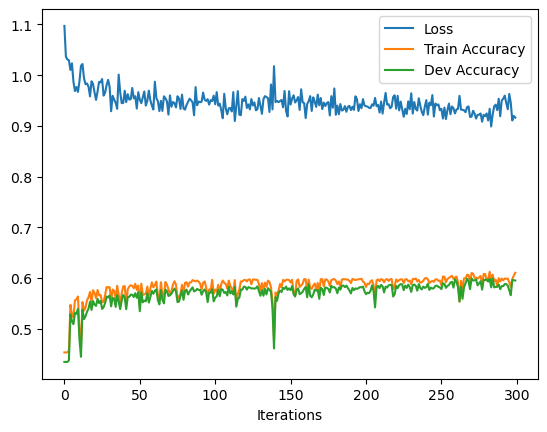

In [36]:
plt.plot(result[0]['loss history'], label='Loss')
plt.plot(result[0]['train accuracies'], label='Train Accuracy')
plt.plot(result[0]['dev accuracies'], label='Dev Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [ ]:
def grid_search_baseline():
    '''
    Performs a grid search to pick the combination of hyperparameters for the Deep Averaging
    Network of the same architecture as the "student" with the best accuracy on the task of
    sentiment analysis.
    
    Fixed parameters:
    - input embedding (pre-trained GloVE embeddings, 50d, vocab of 1.2M)
    - soft label weight (set to 0)
    - learning rate
    - # of layers (2 or 3)
    
    Hyper parameters:
    - dropout probability [0.0, 0.2, 0.4, 0.6, 0.8] 
    
    Returns 
        1) array of dictionaries containing 'train accuracies', 'dev accuracies', 'best iteration' 
        (containing the index of the dev accuracies array with the highest value), 'loss history'
        2) dictionary containing the combination of hyperparameters with the highest dev accuracy
    '''
    return [], {}